# Percolation and cluster growth

### Remarks on completing the module

This assignement is summatively assessed. It is imperative that you submit the notebook on time.



In [1]:
import numpy as np
from scipy import special
import random as R
import math
import pylab as pl
from matplotlib import animation,rc
import matplotlib.pyplot as plt
rc('animation', html='html5')
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
# This cell is hidden from the student's notebook. It generates the buttons used in the answers.
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="test";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None


class myRadioButton:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        def on_value_change(change):
            s=shelve.open('.choices.shelve')
            key=self.getKey()
            s[key]=change['new']
            s.close()

        self.widget=widgets.RadioButtons(
            options=self.options,
            value=get_last_value(self.getKey()),
            description=self.description,
            disabled=False
        )
        self.widget.observe(on_value_change, names='value')

        return self.widget
    def getKey(self):
        return '{0}_{1}'.format(assessmentName,self.name)
        
        
def on_value_change(change):
                s=shelve.open('.choices.shelve')
                key='{0}_{1}_{2}'.format(assessmentName,self.name,i)
                s[key]=change['new']
                s.close()

def make_value_change_fn(assessmentName,name,i):
        def fn(change):
            s=shelve.open('.choices.shelve')
            key='{0}_{1}_{2}'.format(assessmentName,name,i)
            s[key]=change['new']
            s.close()
        return fn

class myCheckBoxSet:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        keys=['{0}_{1}_{2}'.format(assessmentName,self.name,i) for i in range(len(self.options))]    
        self.widgets=[ widgets.Checkbox(value=get_last_value(key),
    description=o,
    disabled=False
        ) for key,o in zip(keys,self.options)]
        
        txt=widgets.HTMLMath(
            value=self.description,
            placeholder='',
            description='',
        )

        
        self.widget=VBox([txt]+self.widgets)
        for i,w in enumerate(self.widgets):
            w.observe(make_value_change_fn(assessmentName,self.name,i), names='value')

        return self.widget
import mywidgets    

## Cluster growth

### The cell below defines the Cluster class. Complete the methods that are only partially implemented.

You can the use the following cells to test your implementation.

Completing the class `Cluster` is the main part of the assignment. Some parts of the methods need to be completed.
The cells below it take you through this, one method at a time. There are also some cells to verify your implementation.

The main components of an instance of the class are:
 - ndim: the dimension of the cluster. We only examine the special case of ndim=2
 - periodic: if True, impose periodic boundary conditions, else, impose isolated boundary conditions
 - size: the extent of a cluster in any dimension
 - grid: a dictionary of positions currently occupied by the cluster, in the form of tuples
      for example ((0,1): True) if element (0,1) is part of the cluster
 - boundary: a dictionary of nearest-neighbours of cluster elements, that are not occupied
 - offsets: a list of all neigbours of location (0,0)
     - for ndim=2, this is simple [(1,0), (-1,0), (0,1), (0,-1)]
 


In [51]:
class Cluster:
    # initialize the cluster
    def __init__(self, ndim=2, size=32, random_number_seed=-1, periodic=False):
        self.size     = size
        self.ndim     = ndim
        self.periodic = periodic
        self.grid     = {}
        self.boundary = None
        
        # Initialize random number generator if random_number_seed is > 0
        if random_number_seed > 0:
            np.random.seed(random_number_seed)
        else:
            np.random.seed(None)
            
        # create list of all nearest neighbours of element (0,) * ndim
        self.offsets = []
        for dim in range(self.ndim):
            offset = np.zeros(ndim, dtype=int)
            offset[dim] = 1
            self.offsets.append(tuple(offset))
            self.offsets.append(tuple(-offset))
        self.noffsets = len(self.offsets)     
            
    #  The function return True / False depending on whether position is inside / outside the grid    
    def element_inside(self, position):
        if self.periodic:
            return True
        sp = np.array(position)
        return (sp >= 0).all() and (sp < self.size).all()

    # This function adds the element at location "position" to the cluster.
    #   It returns an exception if that element is already in the cluster, or if it outside the grid's boundaries
    def element_add(self, position):
        # This routine adds the element at location "position" to the cluster
        #    if the element is already part of the cluster, raise an exception
        #    if periodic=True: wrap position periodically before inserting element
        #    if periodc=False: raise exception if element is outside the grid boundaries
        pos = np.array(position)

        if self.periodic:
            pos  = (pos + 2 * self.size) % self.size
            
        if(self.element_inside(pos)):
            if tuple(pos) in self.grid:
                print(" ++ element_add, Position = ", pos)
                raise Exception("Element is already in cluster")
            else:
                self.grid[tuple(pos)] = True
        else:
            print(" ++ element_add, Position = ", pos)
            raise Exception("Element is outside of grid")
    
    # The function returns the list of all nearest-neighbours of a given position, that are inside the grid
    def element_neighbours(self, position):
        # consistency check:
        if len(position) != self.ndim:
            raise Exception(" Error: this position does not have the right dimension")
            
        # use self.offsets to return a list of all nearest-neighbours of the specified position
        neighbours = []
        for offset in cluster.offsets:
            element = tuple(np.asarray(position) + np.asarray(offset))
            neighbours.append(element)
        return neighbours

    # This functon returns the distance between position1 and position2
    def distance(self, position1, position2):
        # consistency check
        if len(position1) != self.ndim:
            raise Exception("not a valid position 1 in distance")
        if len(position2) != self.ndim:
            raise Exception("not a valid position 2 in distance")
        
        #
        p = np.asarray(position1)
        q = np.asarray(position2)
        distance = 0
        for i in range(len(p)):
            dx = np.abs(p[i]-q[i])
            if self.periodic:
                if dx > self.size/2:
                    dx = self.size - dx
            distance += dx * dx
        return np.sqrt(distance)
    
    # This function returns all the distances from each element of the clyuster, to the given location "position"
    def element_distances(self, position):
        distance = {}
        for element in self.grid:
            distance[element] = self.distance(element, position)
        return distance
    
    # This function periodically wraps "position" on the grid
    def periodic_wrap(self, position):
        if self.periodic:
            return tuple(np.array(position) % self.size)
        else:
            return position
        
        
        
    #########################################################################################################
    #      The three methods below implement the three models for cluster growth (Eden, DLA and Random)     #
    #########################################################################################################
    
    
    # Eden model for cluster growth
    # The algorithm for adding an element is as follows
    #  - pick at random, any unoccupied site that is a nearest neighbour of an element alreadu in the cluster
    #  - add it to the cluster
    # The method below should add 1 element to the cluster based on this algorithm
    def Eden(self):
        
        # The first time Eden in invoked, we create a list, called self.boundary, 
        # of empty sites that neighbour the cluster
        # When Eden is called again, we update self.boundary
        if self.boundary == None:
            # iterate over all neighbours of all elements in the cluster
            #    if the neighbour is not in the cluster, and not in self.boundary, add it to self.boundary
            # YOUR CODE HERE
            self.boundary = {}
            for key in self.grid:
                neighbours = self.element_neighbours(key)
                for neighbour in neighbours:
                    if neighbour not in self.boundary and neighbour not in self.grid:
                        self.boundary[self.periodic_wrap(neighbour)] = True
            
        # pick at random an element of self.boundary, and add this element to the cluster
        # YOUR CODE HERE
        keys = []
        for i in self.boundary.keys():
            keys.append(i)
        random_num = np.random.randint(0, len(keys))
        try:
            self.element_add(keys[random_num])
        except:
            print("there is something wrong")   
        # remove this element from self.boundary
        # YOUR CODE HERE
        self.boundary.pop(tuple(keys[random_num]))
        # add the neighbours of the element to self.boundary,
        #      provided they are not in the cluster, and not already in the boundary
        for neighbour in self.element_neighbours(keys[random_num]):
            if neighbour not in self.grid:
                if neighbour not in self.boundary:
                    if self.element_inside(neighbour):
                        self.boundary[self.periodic_wrap(neighbour)] = True

        # return current number of elements in the boundary             
        return len(self.boundary)

    # DLA model for generating a cluster
    # Start a random walk at distance "radius" away from the seed of the cluster, which is at location "centre"
    # Terminate the walk, if either
    #        walker hits the cluster - then add it to the cluster
    #        crosses the edge, i.e. reaches a distances > edge from the centre
    # DLA adds an element to cluster, and the function returns "track": the list of all sites visited in the 
    #     random walk
    def DLA(self, centre, radius, edge):
        start     = np.asarray(centre)
        cont      = True
        # choose starting point in polar coordinates - then convert to cartesian coordinates
        rad = np.asarray([1, int(radius)])
        rad = rad.max()
        while tuple(start) in self.grid:
            start     = np.asarray(centre)
            phi = 2 * np.pi * np.random.random()  # angle uniform in [0, 2pi[
            x   = rad * np.cos(phi)
            y   = rad * np.sin(phi)
            dr  = np.sqrt(x*x+y*y)

            # round-off to integer coordinates
            start[0] += int(x)
            start[1] += int(y)
            start     = tuple(start)
            
        
        # track stores all the location that the random walk visits
        track   = []
        track.append(start)
        step    = start   # the random walk steps from the current step, "step", to the next step, "next_step"
        for nei in self.element_neighbours(step):
            if nei in self.grid.keys():
#                 print(self.grid)
                self.element_add(step)
                track.append(step)
                cont = False
                break
        while cont:
            # continue walking as long as cont = True
            # take a random step, from step to next_step
            # Hint: use RandomStep, implemented below, or write your own
            # YOUR CODE HERE
            next_step = self.RandomStep(step)
#             raise NotImplementedError()
            
            # If any neighbour of next_step is in the cluster, then:
            #    - add next_step to cluster
            #    - add next_step to track
            #    - set cont = False, to end walk
            # YOUR CODE HERE
            for nei in self.element_neighbours(next_step):
                if nei in self.grid.keys():
#                     print(self.grid)
                    self.element_add(next_step)
                    track.append(next_step)
                    cont = False
                    break
#             raise NotImplementedError()
            
            # if cont is True, we need to check if walker is still in the allowed region
            #     if distance to centre > edge: put cont = False, add element to track, and end walk
            #     if distance to centre < edge: cont = True
            #         - add next_step to track
            #         - put step = next_step
            #         - continue walk
            # YOUR CODE HERE
            if cont:
                if (self.distance(centre, step) > edge):
                    track.append(next_step)
                    cont = False
                else:
                    track.append(next_step)
                    step = next_step
            
        # walk finished: return the track 
        # You may want to uncomment the lines below for debugging your code
#        if attach:
#            print("Walker attached to cluster at position = ", next_step)
#        else:
#            print("walker off grid")
        return track

    # This function randomly adds sites to a grid, based on comparing a uniform random number, prob,
    #      to the input (given) probability "probability"
    def Random(self, probability):
        # for each site: if random number < probability, add element to cluster
        shape  = (self.size,) * self.ndim
        prob   = np.random.rand(*shape)
        assign = np.where(prob < probability)
        assign = np.array(assign).T
        for a in assign:
            self.element_add(a)
            
    #########################################################################################################
    #   The routines below are helper routines                                                              #
    #########################################################################################################

    # Perform a single random step, starting at location "position"
    #     function returns the location of the end of the step
    def RandomStep(self, position):
        itry      = np.random.choice(range(self.noffsets))
        offset    = self.offsets[itry]
        new       = tuple(np.array(position) + np.array(offset))
        return self.periodic_wrap(new)

    
    # Starting from location "position", take nstep random walk steps
    def RandomWalk(self, position, nstep):
        track   = []
        current = position
        for i in range(nstep):
            current  = self.RandomStep(current)
            track.append(current)
        return track
    
    # Plot the current cluster
    #   Input is the cut to plot, and, optionally, the name of the plot, and the name of the file
    #   to save the plot
    def ShowCluster(self, cut, title=None, file=None):
        # extract the cooridnates of the cluster specified by cut 
        xs, ys  = self.ExtractSlice(cut)
        # create the figure, and plot all cluster sites
        fig, ax = pl.subplots(figsize=(11,11))
        ax.set_aspect('equal')
        ax.set_xlim(-1, self.size)
        ax.set_ylim(-1, self.size)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if not title == None:
            ax.set_title(title)
        ax.grid()
        ax.plot(xs,ys,'ro',alpha=0.2)[0]
        
        # save the figure
        if not file == None:
            print("Saving cluster to file: ", file)
            plt.savefig(file)
            
        plt.show()
        
 
    # Extract a slice: this is useful if the cluster is in ndim>2 dimensions
    #    cut specifies the direction to cut the cluster and extract a 2D slice
    def ExtractSlice(self, cut):
        # cut is a tuple of length self.ndim
        # the tuple should have exactly 2 elements equal to -1, which define the plane to extract
        if len(cut) != self.ndim:
            raise Exception(" cut has wrong length")
        plane = np.where(np.asarray(cut) == -1)[0]
        if len(plane) != 2:
            raise Exception(" plane has wrong dimenson ", len(plane))
        for dim in range(self.ndim):
            if dim not in plane:
                if cut[dim] < 0 or cut[dim] >= self.size:
                    raise Exception(" cut is out of range ", dim, cut[dim])
        #
        sites = []
        xs    = []
        ys    = []
        cut = np.asarray(cut)
        for site in self.grid:
            if np.all(np.logical_or(cut==-1,cut==np.asarray(site))):
                sites.append(site)
                xs.append(site[plane[0]])
                ys.append(site[plane[1]])
        return xs, ys        
                
    # This function plots a track, as generated by DLA for example, for a given random walk
    #  Input is the track, and optionally, the name of the file to save the figure
    def ShowTrack(self, track, file=None):
        fig, ax = pl.subplots(figsize=(7,7))
        ax.set_aspect('equal')
        ax.set_xlim(-1, self.size)
        ax.set_ylim(-1, self.size)
        ax.set_xlabel("x-position")
        ax.set_ylabel("y-position")
        ax.set_title("Track of random")
        ax.grid()
        xs = []
        ys = []
        for el in track:
            xs.append(el[0]) 
            ys.append(el[1])
#        ax.plot(xs,ys,'ro',alpha=0.2)[0]
        ax.plot(xs, ys)
 
        # save the figure
        if not file == None:
            print("Saving track to file: ", file)
            plt.savefig(file)
            
        plt.show()  
    

### The cells below, test your implementation of methods in Cluster

If your code does not pass this cell, you should debug your implementation of element_add before continuing

In [52]:
# initialize a small cluster
size     = 5          # size of cluster
ndim     = 2          # dimensionallity of cluster
periodic = True       # boundary condition
cluster  = Cluster(ndim=ndim, size=size, periodic=periodic)

# add a single element at the centre
cent = int(size/2)          # location of seed
seed = (cent,) * ndim       # seed of cluster
cluster.element_add(seed)

# Provided your implementation is correct, cluster.grid = {{2,2)}: True}
test = {(2,2): True}
if cluster.grid == test:
    print("That's right! -- continue")
else:
    print("you made and error in implementing add_element")

# Using the list of offsets, add the neighbour to the right of the seed to the cluster
offset  = cluster.offsets[0]
element = tuple(np.asarray(seed) + np.asarray(offset))
print("We are adding element = ", element)
cluster.element_add(element)
test2 = {(2, 2): True, (3, 2): True}
if cluster.grid == test2:
    print("That's right! -- continue")
else:
    print("you made and error in implementing add_element")

# Test adding an element that is already in the cluster
try:
    cluster.element_add(seed)
    print(" this should not happen: element should not be added twice ")
except:
    print("That's right! -- continue")
    pass    

# Test periodic wrapping
element = (2*size, int(size/2))  # this element is outside of the grid, but we are using periodic boundary conditions
print("We are adding element = ", element)
cluster.element_add(element)
test3 = {(2, 2): True, (3, 2): True, (0, 2): True}
if cluster.grid == test3:
    print("That's right! -- continue")
else:
    print("you made and error in implementing add_element (periodic boundary conditions)")

    
    
# now test non-periodic cluster
cluster  = Cluster(ndim=ndim, size=size, periodic=False)
try: 
    cluster.element_add(element)
    print(" this should not happen: element should not be added")
except:
    print("That's right! -- continue")
    pass

That's right! -- continue
We are adding element =  (3, 2)
That's right! -- continue
 ++ element_add, Position =  [2 2]
That's right! -- continue
We are adding element =  (10, 2)
That's right! -- continue
 ++ element_add, Position =  [10  2]
That's right! -- continue


In [53]:
# This cell test your implementation of the "element_neighbours" method"

# create a small cluster and add some elements to it
size     = 7          # size of cluster
ndim     = 2          # dimensionallity of cluster
periodic = False      # boundary condition
cluster  = Cluster(ndim=ndim, size=size, periodic=periodic)

# start with seed at centre, and add all off its neighbours
cent = int(size/2)          # location of seed
seed = (cent,) * ndim       # seed of cluster
cluster.element_add(seed)
for offset in cluster.offsets:
    element = tuple(np.asarray(seed) + np.asarray(offset))
    cluster.element_add(element)

# list all neighbours of some positions
neighbours = cluster.element_neighbours(seed)
test = [(4, 3), (2, 3), (3, 4), (3, 2)]
if neighbours == test:
    print(" That's right! -- continue")
else:
    print("you made an error in implementing element_neighbours")

 That's right! -- continue


### The Eden model of cluster growth

Use the methods you have implemented so far, to complete implementing the Eden model.
The growth algortihm is as follows (see lecture notes)
    - at start-up, create self.boundary - a list of all valid, empty sites that are nearest-neighbours of cluster elements
    - pick randomly one of the elements in the list of boundary cells, self.boundary
        - add it to the cluster
        - remove it from the list of empty boundary sites
        - add its neighbours to the list of boundary sites, provided theya re not in the cluster and not already in the list of boundary sites
        
        



Saving cluster to file:  Eden.pdf


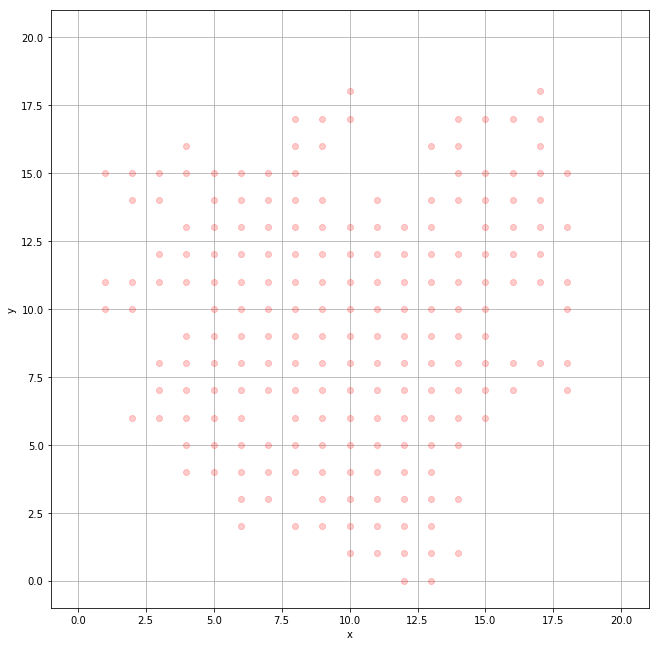

In [54]:
size     = 21         # size of cluster
ndim     = 2          # dimensionallity of cluster
periodic = False      # boundary condition
cluster  = Cluster(ndim=ndim, size=size, random_number_seed = 1, periodic=periodic)
cent     = int(size/2)
seed     = (cent,) * ndim       # seed of cluster

cluster.element_add(seed)
nsites = 200               # add nsites=200 elements to the Eden cluster
for i in range(nsites):
    cluster.Eden()

cut   = [-1, -1]
file  = 'Eden.pdf'
#file  = 'Eden_solution.pdf'
title = 'Eden cluster'
cluster.ShowCluster(cut, file=file)

# Compare your result to Eden_solution.pdf


### Fractal dimension of Eden cluster


In the next cell:
 - Generate an Eden cluster with the parameters given (size, ndim, periodic, and location of starting seed)
 - Compute the distance of each element to the seed
 - Sort the distance in ascending order
 - Plot the enclosed mass as a function of radius. Assume that each element has mass = 1
 
Compare your answer to Eden_mass.pdf 


 max radius = 16.401219466856727


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


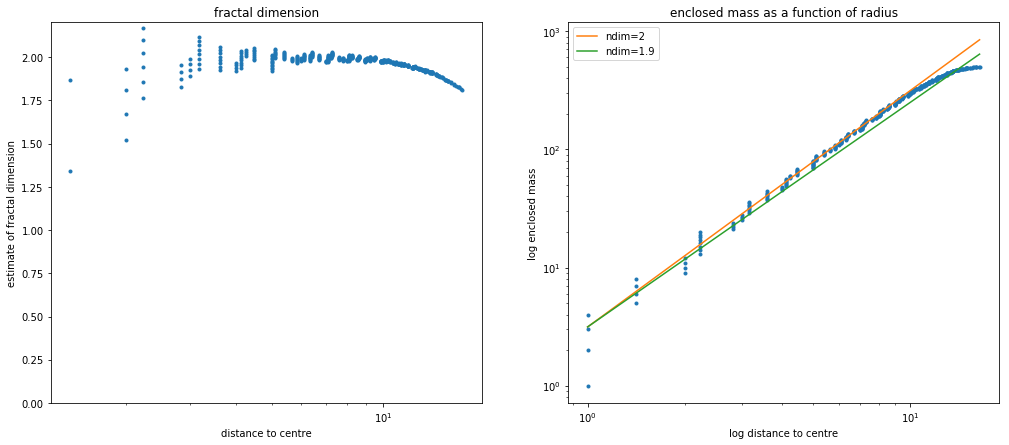

In [55]:
size       = 101
ndim       = 2
periodic   = False
cent       = int(size/2)
seed       = (cent,) * ndim       # seed of cluster
nsites     = 499

# YOUR CODE HERE
cluster = Cluster(ndim=ndim, size=size, periodic=periodic)
cluster.element_add(seed)
for i in range(nsites):
    cluster.Eden()

# radius is an array of all the distances of each element to seed, sorted in ascening order
# you may want to exclude from it the seed itself

radius = []
for point in cluster.grid.keys():
    radius.append(cluster.distance(seed, point))

radius.sort()
radius = radius[1:]

radius = np.array(radius)
# provide some statistics
print(" max radius =", radius.max())


# unit volume of ndim dimensional sphere
vol = np.pi # special case for ndim = 2
mass = 500
# estimate fractal dimension

dimen = []
mass = [i + 1 for i in range(499)]
for i in range(len(radius)):
    dimen.append(np.log(mass[i]/vol) / np.log(radius[i]))

# plot the result
fig, ax = pl.subplots(1, 2, figsize=(17,7))
ax[0].set_ylim(cluster.ndim-2, cluster.ndim+0.2)
ax[0].set_xlabel('distance to centre')
ax[0].set_ylabel('estimate of fractal dimension')
ax[0].plot(radius, dimen, '.')
ax[0].set_xscale('log')
ax[0].set_title('fractal dimension')

# enclosed mass as a function of radius
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(radius, mass, '.')
ax[1].set_xlabel('log distance to centre')
ax[1].set_ylabel('log enclosed mass')
ax[1].set_title('enclosed mass as a function of radius')

# overplot mass-radius relation for ndim = 2
mfit2 = vol * radius**(2)
ax[1].plot(radius, mfit2, label='ndim=2')

# overplot mass-radius relation for ndim = 1.9
d     = 1.9
mfitd = vol * radius**(d)
ax[1].plot(radius, mfitd, label='ndim=1.9')
ax[1].legend()
# plt.savefig("Eden_mass.pdf")
plt.show()


Now generate 2000 realisation of an Eden cluster with the parameters of the cell above.
Compute the fractal dimension $d$, defined as $m=\pi r^d$, where $m$ is the mass enclosed with radius $r$,
for $r=9$. 

Plot a histogram of the values of $d$. **Annotate** the plot with axes labels, and save it as **histogram.pdf**

Compute the mean value and dispersion of d. Report your values in the cells below to the required precision.

In [56]:
# YOUR CODE HERE
size       = 101
ndim       = 2
periodic   = False
cent       = int(size/2)
seed       = (cent,) * ndim       # seed of cluster
nsites     = 499
times      = 2000
dimen      = []
radius     = 9
vol        = np.pi
for i in range(times):   
    cluster = Cluster(ndim=ndim, size=size, periodic=periodic)
    cluster.element_add(seed)
    for i in range(nsites):
        cluster.Eden()
    mass = 0
    for point in cluster.grid.keys():
        if cluster.distance(seed, point) <= radius:
            mass += 1
    dimen.append(np.log(mass/vol) / np.log(radius))

  

print("Calculation finished")    

Calculation finished


### Compute and plot a histogram of estimates of the fractal dimension.

** 2 marks **


1.979462488039539
0.008613000772697076


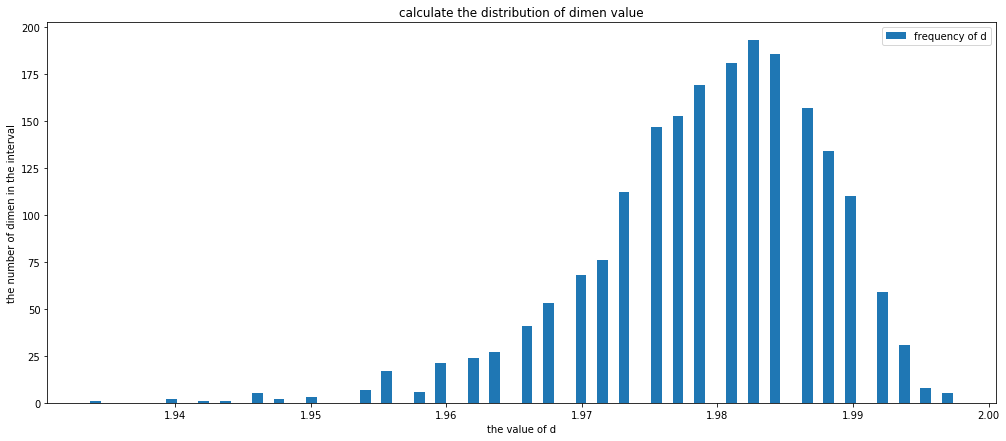

In [19]:
# use this cell to 
# -- compute a histgram of the dimensions "dimen", estimate for each of the nEden Eden clusters
# -- plot this histogram and save it to a file, called Eden_fractal.pdf
#    Annote the histogram: add labels to the axes

print(np.mean(dimen))
print(np.std(dimen))
# YOUR CODE HERE
fig, ax = pl.subplots(1, 1, figsize=(17,7))
ax.set_xlabel('the value of d')
ax.set_ylabel('the number of dimen in the interval')
ax.set_title('calculate the distribution of dimen value')
ax.hist(dimen,label='frequency of d', bins=80)
ax.legend(loc='best')
plt.savefig("Eden_fractal.pdf")


Compute the mean (**2 marks**) and standard deviation (**2 marks**) of the fractal dimension.
Enter your values in the boxes below. Execute the hidden cells below if the boxes do not appear.

In [3]:
dimen=mywidgets.myFloatBox('Percolation','P1','Dimension=', 'Enter your estimate of the mean fractal dimension to a least 3 significant figures')
dimen.getWidget()



In [4]:
dimen_var=mywidgets.myFloatBox('Percolation','P2','stdev =', 'Enter your estimate of the standard deviation of the dimension to at least 3 significant figures')
dimen_var.getWidget()


## The DLA model of cluster growth

Use the methods you have implemented so far, to complete the implemention of the DLA model of cluster growth (see course notes). In brief, the growth algorithm is as follows:

- create a cluster with a single seed at the centre, using the Cluster class you've developped
- choose an inner radius, $r_1$, and an outer radius $r_2$.
    - start a random walker from a location at distance close to $r_1$ from the seed, and let it walk
        - if it hits any part of the existing cluster, add it to the cluster, and start a new walk
        - if it crosses the outer boundary, $r>r_2$, terminate the random walk, and start a new walk
- terminate the programme, when the cluster contains a specified number of elements
        
You may want to base the random walk on the implementation you wrote in lecture 6 on random walks

Use the cells below to test intermediate steps of this assignment

        
      

In [22]:
# create a cluster, and add a seed to the centre
size       = 101                  # the size here is only ever used for plotting
ndim       = 2                    # we only do the 2 dimensional case
periodic   = False                # non-periodic grid
cent       = int(size/2)          # put the seed in the center of the grid
seed       = (cent,) * ndim       # seed of cluster

# We specify a random number seed for this test, so you should always get the same shape of walk
dla = Cluster(ndim=ndim, size=size, random_number_seed=12, periodic=periodic)
dla.element_add(seed)

Saving track to file:  Randomwalk.pdf


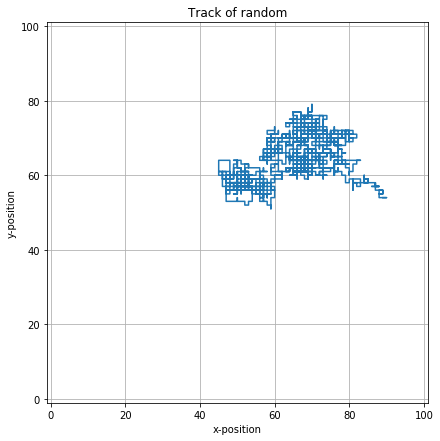

In [23]:
# as an example, perform a single walk to see what happens
centre = seed
radius = 20
edge   = 40
track  = dla.DLA(centre, radius, edge)
#file   = "Randomwalk_solution.pdf"
file   = "Randomwalk.pdf"

# the call below plots the track the random walk followed, before it terminated
#     - either by travelling further than 'edge' from the seed
#     - or by hitting the seed
dla.ShowTrack(track, file=file)

# you may want to compare your answer to the file "Randomwalk_solution.pdf"
# It should not look identical, but if it looks very different you may have a bug somewhere in your code

### Now create a DLA cluster with nel = 400 elements in it

Use the cell below it plot the DLA cluster and saving the plot to a file.

Take care with the parameter 'radius' and 'edge'.
The values in the cell below are reasonable initialize values from where to start the walk (at a distance "radius" from the centre of the DLA cluster), and for when to abort the random walk (if the walker ventures further than "edge' from the centre of the cluster). However, as the cluster grows in size, you will need to increase both "radius" and "edge".
    - If radius is too small, the centre of the cluster will be densely filled,
        since all walkers are started too close in.
    - If edge is too small, you again get a cluster that is too centrally concentrated.
    - If edge and or radius are too large, then the code becomes very inefficient, because the walker can run everywhere with little chance of ever hitting the cluster.

Therefore, you may want to experiment with both these parameters.

** 4 marks **


In [24]:
# Use this cell to compute the DLA cluster
# The use the next cell to plot it and save it to a file called "DLA.pdf"
#       You may want to use the ShowCluster method for plotting, with cut=[-1,-1]


# start with these parameters for the cluster
size     = 101                  # size is only relevant for plotting and setting the starting location
cent     = int(size/2)
seed     = (cent,) * ndim       # seed of cluster
periodic = False
dla      = Cluster(ndim=ndim, size=size, random_number_seed=12, periodic=periodic)
dla.element_add(seed)

# name of file to save result, and location of cut to plot
cut      = [-1, -1]
file     = 'DLA.pdf'

#
centre = seed
radius = 10
edge   = 20
nel    = 400


    
# YOUR CODE HERE
# raise NotImplementedError()
count = 0
while len(dla.grid.keys()) < nel:
    count += 1
    increasing = count / nel * 15
    dla.DLA(centre, radius + increasing, edge + 2 * increasing)
print("Calculation is finished")




Calculation is finished


Saving cluster to file:  DLA.pdf


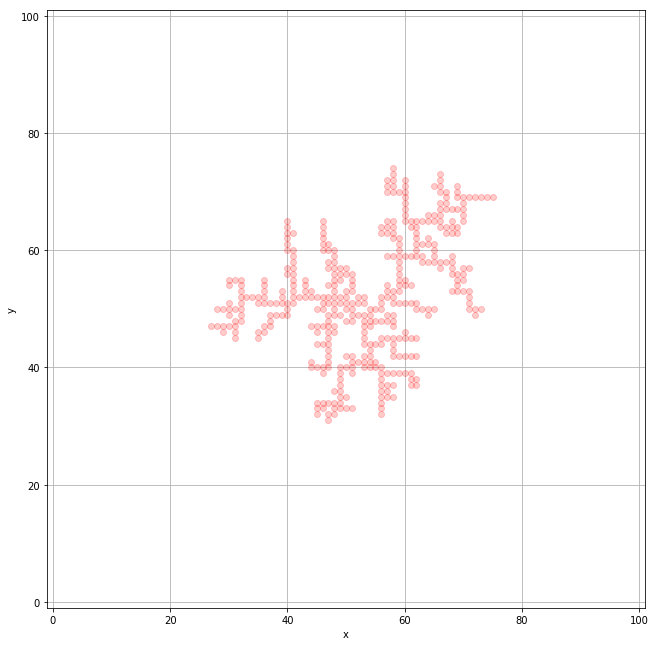

In [25]:
dla.ShowCluster(cut, file=file)

## Percolation

### The cell defines a class GroupFinder that identifies groups in a cluster.

The structure of the cluster required by GroupFinder is the same as what we had so far. The Eden cluster, or DLA clusters, have the right format. Given a cluster, the groupfinder partitions the elements in a cluster by making
sure that ** any two elements of the cluster that are nearest-neighbours, belong to the same group**.




In [26]:
# This class contains methods to
#   - identify all groups in  a given cluster
#        a group is a set of sites that are neaarest-neighbours
#   - examine whether a group percolates
# You should not have to edit any of these methods
# Use the cells below to learn how to use the method to identify groups, and examine percolation
class GroupFinder():
    # return a list of connected clusters
    def __init__(self, cluster):
        self.cluster = cluster
        # Each element within a group will point to a common element of the group - the head
        self.heads   = {}
        for element in self.cluster.grid:
            self.heads[element] = element  # initialize by assuming each element is in its own group
            
    # Iteratively loop over all elements in the cluster to identify groups
    def FoF(self):
        # Begin partitioning 
        #    We only loop over pairs of neighbours
        maxcount = 10000
        for element in self.cluster.grid:
            element_head = element
            count = 0
            while element_head != self.heads[element_head] and count < maxcount:
                element_head = self.heads[element_head]
            count = 0
            for neighbour in self.cluster.element_neighbours(element)[::2]:
                count = 0
                if neighbour in self.cluster.grid:
                    neighbour_head = neighbour
                    while neighbour_head != self.heads[neighbour_head] and count < maxcount:
                        count += 1
                        neighbour_head = self.heads[neighbour_head]
                    self.heads[neighbour_head] = element_head
            if count == maxcount:
                raise Exception("Error: partitioning does not converge")

        #
        count = 0
        for element in self.cluster.grid:
            element_head = element

            while element_head != self.heads[element_head] and count < maxcount:
                element_head = self.heads[element_head]
            self.heads[element] = element_head
        
        
        unique  = {}
        ngroups = 0
        for head in self.heads:
            if head not in unique:
                unique[head] = ngroups
                ngroups     += 1
        
        groupid = []
        for element in self.cluster.grid:
            groupid.append(unique[self.heads[element]])

        return np.asarray(groupid)

    # Alternative group finder   
    def Groups(self):
        groupid    = np.arange(len(self.cluster.grid), dtype=int)
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
        success = False
        count   = 0
        while not success:
            success = True
            for element in self.cluster.grid:
                for neighbour in self.cluster.element_neighbours(element):
                    if neighbour in self.cluster.grid:
                        indx1 = groupid[groupindx[element]]
                        indx2 = groupid[groupindx[neighbour]]
                        if indx1 < indx2:
                            groupid[groupid==indx2] = indx1
                            success = False
                            count += 1
                        elif indx1 > indx2:
                            groupid[groupid==indx1] = indx2
                            success = False
                            count += 1
            print(" count = ", count)
        return groupid

    # Examine the percolation of groups identified using a group finder
    # Loop over all unique groups in groupdid
    #     for each group, loop over all dimensions
    #     if a group percolates, store its id and the dimension that it percoaltes in
    #   return this to the calling routine
    def PercolateGrid(self, groupid):
        # determine whether thisgroup percolates
        
        # consistency: only works for non-periodic grids
        if self.cluster.periodic:
            raise Exception(" We only implement non-periodic grids ")
            
        #     
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
         
        # extract group by group
        result = []
        for group in np.unique(groupid):
            newcluster = Cluster(self.cluster.ndim, self.cluster.size, self.cluster.periodic)
            for element in self.cluster.grid:
                if groupid[groupindx[element]] == group:
                    newcluster.grid[element] = True 
                    
            # find whether this group percolates
            for dimen in range(self.cluster.ndim):
                if self.PercolateGroup(newcluster, dimen):
                    result.append([group, dimen])
        return result                
    
    # This method examines whether a given group percolates in a given dimension
    def PercolateGroup(self, cluster, dimen):
        # inputs:
        #    self: the class GroupFinder
        #    cluster: one of the groups identified by the group finder
        #    dimen: the dimension to check for percolation

        # consistency check
        if dimen < 0 or dimen >= cluster.ndim:
            raise Exception(" too many dimensions ")
        
        # Determine with this cluster touches both boundaries in dimension dimen of the dimensions simultaneously
        x = [sp[dimen] for sp in cluster.grid.keys()]
        return (min(x) == 0 and max(x) == cluster.size-1)

    ####### The routines below are ueful for plotting groups #################
    def ExtractGroup(self, groupid, plotid, cut):
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
            
        newcluster = Cluster(self.cluster.ndim, self.cluster.size, self.cluster.periodic)
        for element in self.cluster.grid:
            if groupid[groupindx[element]] == plotid:
                newcluster.grid[element] = True
            
        xs, ys  = newcluster.ExtractSlice(cut)
        return xs, ys    
    
    def ShowGroup(self, groupid, plotid, cut):
        xs, ys = self.ExtractGroup(groupid, plotid, cut)
        ax.plot(xs, ys, 'o',alpha=0.2)[0]

   

### Examine the cell to see how the methods of GroupFinder and Cluster can be used to
 - create a cluster to work on
 - identify the groups inside the cluster
 - plot the result


 Number of elements in groups =  [1823, 2311, 3989, 1882]
 Number of unique groups =  4
 Number of elements in largest group =  3989


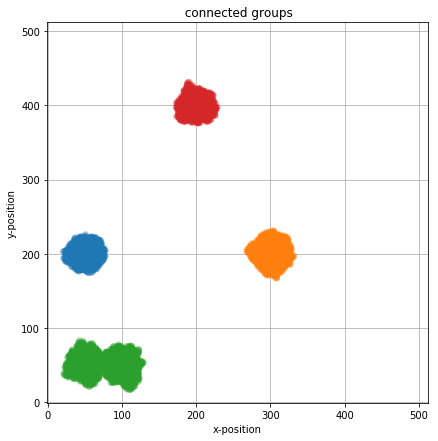

In [27]:
# set-up the grid parameters
size      = 512
ndim      = 2
periodic  = True
rseed     = 12
cluster   = Cluster(size=size, ndim=ndim, periodic=periodic, random_number_seed = rseed)

# Use the Eden model to grow some clusters
#    start woth 5 seperate seeds
seed1     = (50,50)
seed2     = (50,200)
seed3     = (100,50)
seed4     = (200,400)
seed5     = (300,200)
cluster.element_add(seed1)
cluster.element_add(seed2)
cluster.element_add(seed3)
cluster.element_add(seed4)
cluster.element_add(seed5)

# run the Eden model, growing each seed
for i in range(10000):
    cluster.Eden()

# Identify the groups
groupfinder = GroupFinder(cluster)

# Assign each element to its group. Elements of the same group have the same groupid
groupid     = groupfinder.FoF()

grouplen    = []

# Next, count the number of elements in each seperate group
for id in np.unique(groupid):
    grouplen.append(len(np.where(groupid == id)[0]))
print(" Number of elements in groups = ", grouplen)
    
    
# Print some statistics    
print(" Number of unique groups = ", len(np.unique(groupid)))
print(" Number of elements in largest group = ", max(grouplen))

# Now plot all groups, using different colours for each group
fig, ax = pl.subplots(1, 1, figsize=(7,7))
ax.set_aspect('equal')
ax.set_xlim(-1, cluster.size)
ax.set_ylim(-1, cluster.size)
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_title(' connected groups')
ax.grid()
for id in np.unique(groupid):
    xs, ys = groupfinder.ExtractGroup(groupid, id, cut)
    ax.plot(xs, ys, 'o', alpha=0.2)[0]
    
# plot a histogram of the size distribution    
#hist, edges = np.histogram(grouplen, bins = 5)
#centre = 0.5 * (edges[1:]+edges[0:-1])
#ax[1].plot(centre, hist)
    
plt.show()

# Description: we grew Eden clusters starting at 5 different locations.
# Running the group finder, we identified 4 seperat groups - as you can see, the green group consists
#     of 2 Eden clusters that now touch - and hence are only one group

We will now use the group finder to study percolation.

Begin by examining the method "Random" in the class Cluster, which has as parameter $p$, in addition to size, ndim and periodic. 

In this method, we generate a random number, $r$, for each grid point of square mesh, [size, size] in extent.
If $r<p$, then we add this element to the cluster.

 generating sample grid with probability =  0.2  fraction of occupied elements=  0.1968


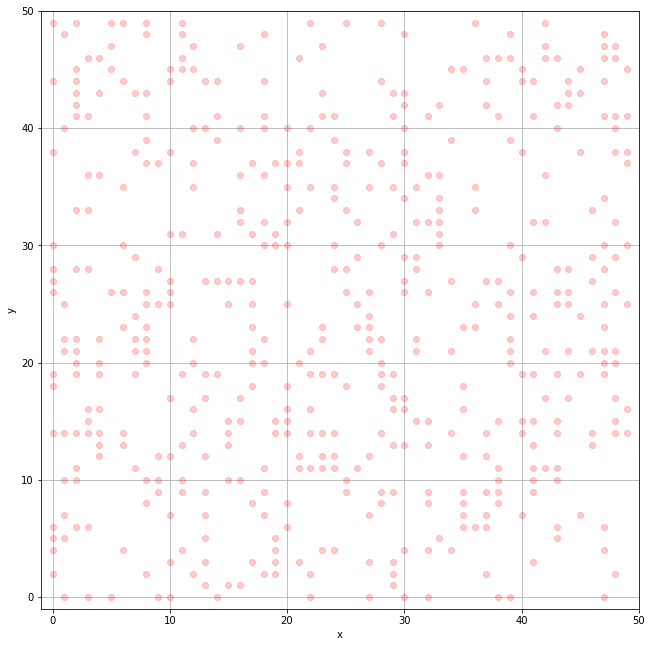

 generating sample grid with probability =  0.4  fraction of occupied elements=  0.3932


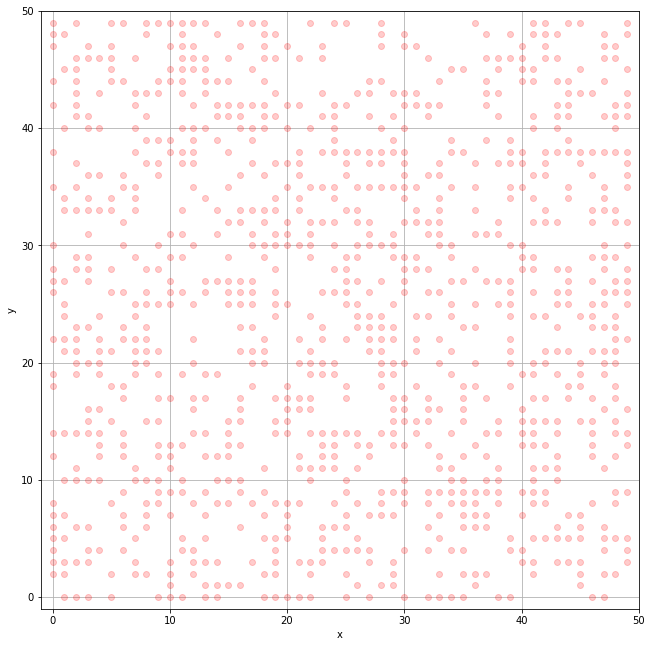

 generating sample grid with probability =  0.6  fraction of occupied elements=  0.5944


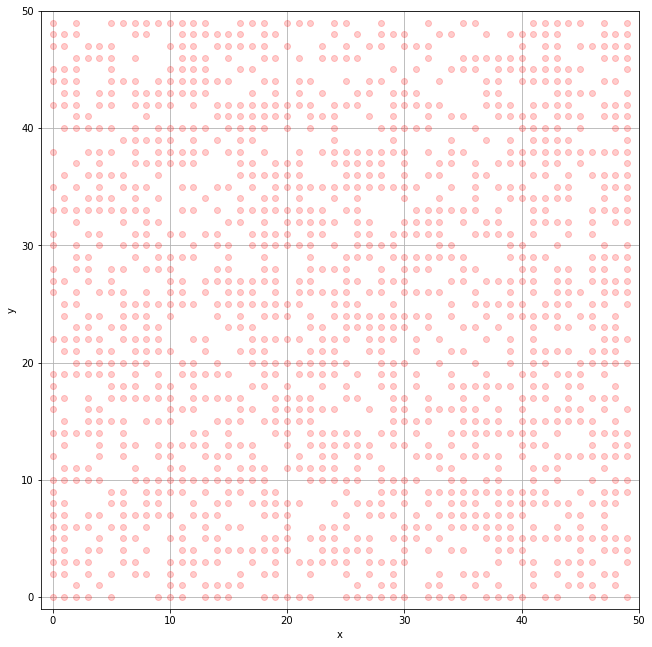

In [28]:
# Example of the method Cluster.Random for generating a cluster of points on a regular grid, with a given probability

size = 50         # size of the grid
ndim = 2          # dimensionality

# variable needed by ShowCluster
cut = np.zeros(ndim)
cut[0] = -1
cut[1] = -1
cut    = tuple(cut)

# generate some with different probabilities as an example

# first example
probability = 0.2
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)

# second example
probability = 0.4
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)

# third example
probability = 0.6
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)




 generating sample grid with probability =  0.59  fraction of occupied elements=  0.6
 Number of unique groups =  88
 Biggest group =  625


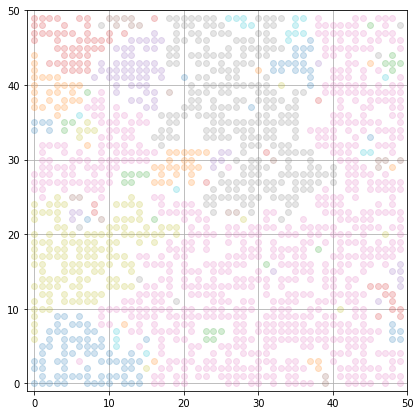

In [29]:
# we now use the group finder to identify clusters in this random grid
probability = 0.59
cluster = Cluster(ndim=ndim, size=size, random_number_seed=3, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)

groupfinder = GroupFinder(cluster)
groupid     = groupfinder.FoF()
grouplen    = []
for id in np.unique(groupid):
    grouplen.append(len(np.where(groupid == id)[0]))

print(" Number of unique groups = ", len(np.unique(groupid)))
print(" Biggest group = ", max(grouplen))

fig, ax = pl.subplots(1, 1, figsize=(7,7))
ax.set_aspect('equal')
ax.set_xlim(-1, cluster.size)
ax.set_ylim(-1, cluster.size)
ax.grid()
for id in np.unique(groupid):
    xs, ys = groupfinder.ExtractGroup(groupid, id, cut)
    ax.plot(xs, ys, 'o', alpha=0.2)[0]

### Assignment

Having played with random grids, and dividing a cluster into a set of connected groups, we will analyse
the appearance of a **percolating** cluster. A percolating cluster, is a group that touches both sides of the grid
(either in the (horizontal) $x$-direction, or in the (vertical) $y$-direction). In the example above, you will see that the pink cluster percolates in the vertical direction, but not in the horizontal direction.

If the probability $p$ is small, then most clusters are small as well, and usually none of them percolates. If the probability $p$ is large, then there is usually one large cluster that percolates in either $x$ or $y$, or indeed in both directions.

As discussed in the lecture, the transition between these two regimes - no percolating cluster on average at low $p$, versus the presence of one or more peroclating clusters, depends on size, and on the value of $p$. Let $p_c$ be the characteristic value of $p$ where the transition happens. Operationally we will define $p_c$ as follows:

  - $p<p_c$: the average number of percolating clusters is < 50 per cent
  - $p>=p_c$: the average number of percolating clusters is >= 50 per cent

To determine the average, we need to generate many random grids with a given value of $p$.

Proceed as follows:

 - Generate a number of random clusters for a range of values of $p$. Set size=50, and ndim=2, periodic=False
 - For each cluster, identify the groups, and examine whether any of the groups percolates. Compute the fraction, $f_{\rm perc}$, of clusters with this value of $p$, that have (one or more) percoalting groups
- Plot $f_{\rm perc}$ versus $p$ to estimate $p_c$.
- Reduce the range in $p$ to zoom in on $p_c$, and increase the number of clusters generated per $p$ value, to measure $p_c$ more accurately.
- Compute and report your value of $p_c$ to 3 significant digits.


In [30]:
# Use this cell to zoom in on the calculation of $p_c$
# YOUR CODE HERE
size=50
ndim=2
calculate_times = 1000
# probabilitys = [0.57 + 0.001 * i for i in range(20)]
probabilitys = [0.5775 + i * 0.0001 for i in range(61)]
# probabilitys = [0.5 + i * 0.005 for i in range(41)]
print(probabilitys)
f_perc = []
for probability in probabilitys:
    count = 0
    for i in range(calculate_times):
        cluster = Cluster(ndim=ndim, size=size, periodic=False)
        cluster.Random(probability)
        groupfinder = GroupFinder(cluster)
        groupid     = groupfinder.FoF()
        if(groupfinder.PercolateGrid(groupid)):
            count += 1
    f_perc.append(count / calculate_times)



print(f_perc)
    

print(" Calculation finished") 

[0.5775, 0.5776, 0.5777, 0.5778, 0.5779, 0.578, 0.5781000000000001, 0.5782, 0.5783, 0.5784, 0.5785, 0.5786, 0.5787, 0.5788, 0.5789, 0.579, 0.5791000000000001, 0.5792, 0.5793, 0.5794, 0.5795, 0.5796, 0.5797, 0.5798, 0.5799, 0.58, 0.5801000000000001, 0.5802, 0.5803, 0.5804, 0.5805, 0.5806, 0.5807, 0.5808, 0.5809, 0.581, 0.5811000000000001, 0.5812, 0.5813, 0.5814, 0.5815, 0.5816, 0.5817, 0.5818, 0.5819, 0.582, 0.5821000000000001, 0.5822, 0.5823, 0.5824, 0.5825, 0.5826, 0.5827, 0.5828, 0.5829, 0.583, 0.5831000000000001, 0.5832, 0.5833, 0.5834, 0.5835]
[0.437, 0.452, 0.448, 0.439, 0.487, 0.46, 0.447, 0.496, 0.464, 0.48, 0.492, 0.46, 0.485, 0.489, 0.483, 0.453, 0.489, 0.475, 0.471, 0.478, 0.461, 0.491, 0.49, 0.486, 0.514, 0.526, 0.471, 0.471, 0.487, 0.483, 0.5, 0.511, 0.51, 0.498, 0.488, 0.497, 0.522, 0.514, 0.542, 0.534, 0.522, 0.512, 0.508, 0.512, 0.516, 0.527, 0.531, 0.509, 0.477, 0.512, 0.544, 0.533, 0.54, 0.552, 0.552, 0.556, 0.554, 0.545, 0.549, 0.542, 0.537]
 Calculation finished


Plot the relation $f_{\rm perc}$ versus $p$ close to $p_c$. Use the curve to estimate $p_c$.
Save the plot to a file called "pc.pdf"

** 2 marks **

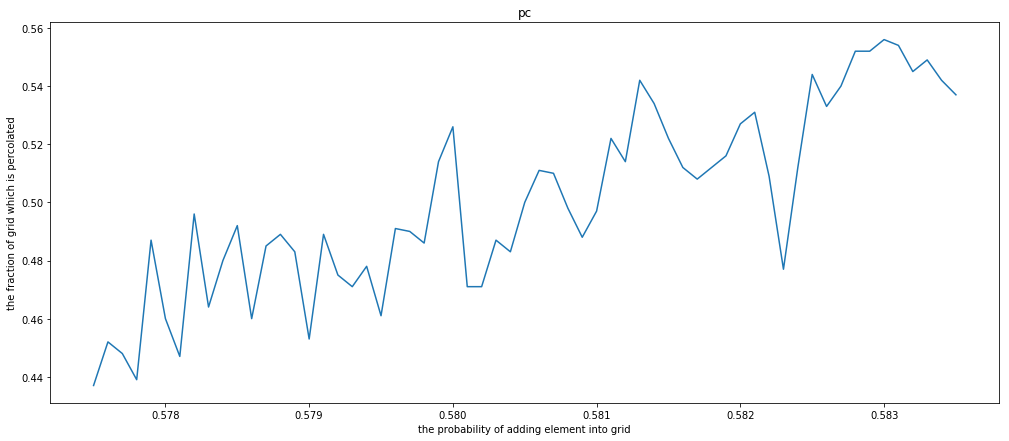

In [33]:
# use this cell to plot the histogram and save the answer to "pc.pdf"
# YOUR CODE HERE
file = "pc.pdf"  
fig, ax = pl.subplots(1, 1, figsize=(17,7))
ax.set_xlabel('the probability of adding element into grid')
ax.set_ylabel('the fraction of grid which is percolated')
ax.set_title('pc')
ax.plot(probabilitys, f_perc)
plt.savefig(file)

Compute the value of $p_c$. Enter your value in the box below. Execute the hidden cell below if the box is not visible.

In [5]:
perc=mywidgets.myFloatBox('Percolation','P4','$p_c$ =', 'Enter your estimate of the critical value $p_c$ to at least three significant figures')
perc.getWidget()
